In [1]:
import sys,os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch 
from QuantumWalkModule.OneDimensionQW import QW_base_pure
from QuantumWalkModule.Operator import Op
from QuantumWalkModule.StatesPreparation import *
from scipy.linalg import expm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [4]:
class Experiment1(QW_base_pure):
    def __init__(self, dim : int, coin_conf : dict, diss_conf : dict) -> None:
        self.dim = dim
        self.S = self.Step()
        self.C1, self.C2 = self.Coin(**coin_conf)
        self.S1, self.S2 = self.Step()
        self.G1,self.G2 = self.Diss(**diss_conf)
        self.U = self.S1 @ self.C1 @ self.G1 @ self.S2 @ self.C2 @ self.G2
        self.st_gen = States(self.dim)

    def Diss(self, **kwargs) -> torch.tensor:   
        g = kwargs.get("g", 0.1)
        gam = kwargs.get("gam", 0.1)
        H = g * Op.sx + 1j * gam * Op.sz
        G = expm(-1j * H)
        Gp = expm(1j*H)
        return torch.kron(torch.eye(self.dim),G), torch.kron(torch.eye(self.dim),Gp)

    def Step(self) -> torch.tensor :
        right = torch.kron(torch.roll(torch.eye(self.dim),1,0), Op.s_l)
        right += torch.kron(torch.eye(self.dim),Op.s_r) 
        left = torch.kron(torch.roll(torch.eye(self.dim),-1,0), Op.s_r)
        left += torch.kron(torch.eye(self.dim),Op.s_l) 
        return right.to(torch.complex64),left.to(torch.complex64)
    
    def make_step(self, state):
        return self.U @ state
    
    def Coin(self, **kwargs) -> tuple:
        th_plus = kwargs.get("th1", np.pi/4)
        th_minus = kwargs.get("th2", np.pi/4)
        C_standard = lambda th : torch.tensor([[np.cos(th/2), -np.sin(th/2)], [np.sin(th/2), np.cos(th/2)]])
        bulk = torch.diag(torch.tensor([1 if i != 0 and  i != self.dim-1 else 0 for i in range(self.dim)]))
        boundary = torch.diag(torch.tensor([0 if i != 0 and  i != self.dim-1 else 1 for i in range(self.dim)]))
        C_plus = torch.kron(bulk,C_standard(th_plus)) + torch.kron(boundary, Op.sx)
        C_minus = torch.kron(bulk,C_standard(th_minus)) + torch.kron(boundary, Op.sx)
        return C_plus.to(torch.complex64), C_minus.to(torch.complex64)

In [5]:
def get_U(k,th1,th2,gam,g):
    S1 = expm(-1j * k * Op.s_r)
    S2 = expm(1j * k * Op.s_l)
    C1 = expm(-1j * th1 * Op.sy / 2)
    C2 = expm(-1j * th2 * Op.sy / 2)
    G1 = expm(-1j * g * Op.sx + gam * Op.sz / 2)
    G2 = expm(1j * g * Op.sx - gam * Op.sz / 2)
    U = S1 @ C1 @ G1 @ S2 @ C2 @ G2
    return U

In [47]:
gs = [0.0,0.1,0.2,0.3,0.4,0.5]
dim = 10
k = (np.arange(0,dim) - dim //2 ) * np.pi/dim
th1 = np.pi/2
th2 = -np.pi/3
gam = np.arange(-1,1,0.01)
Energies_upper = []
for g in gs:
    Energies = []
    for gam_ in gam:
        Energies_inner = []
        for k_ in k:
            U = get_U(k_,th1,th2,gam_,g)
            E = np.linalg.eigvals(U)
            E = 1j * np.log(E)
            E_real = E.real
            E_imga = E.imag
            Energies_inner += list(E)
        Energies_inner = np.array(Energies_inner)
        Energies_inner = np.sort(np.abs(Energies_inner.real)) + 1j * np.sort(np.abs(Energies_inner.imag))
        Energies_inner[1::2] *= -1
        Energies.append(Energies_inner)
    Energies = np.array(Energies)
    Energies_upper.append(Energies)

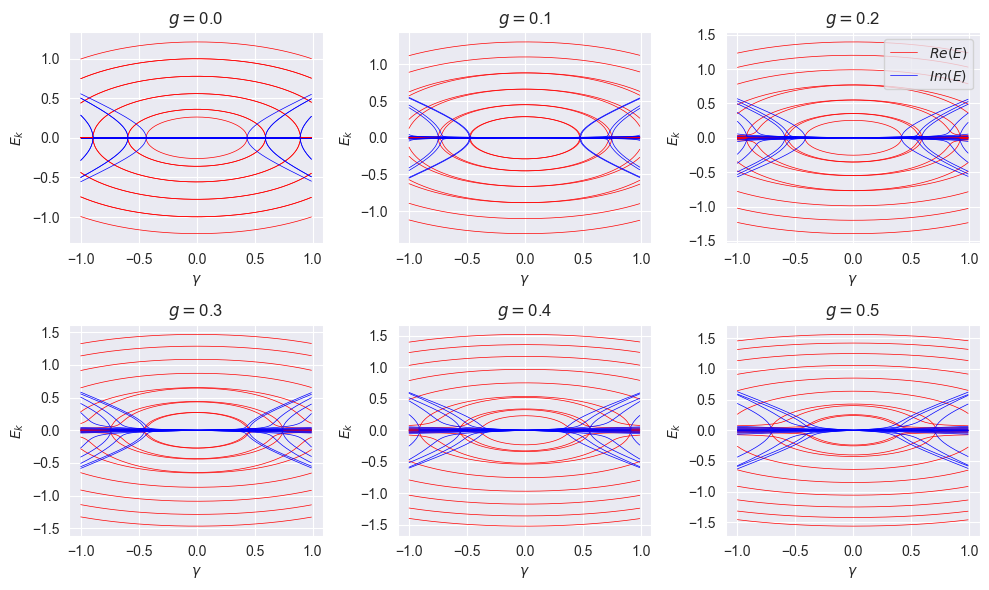

In [57]:
fig = plt.figure(figsize = (10,6))

for j in range(len(gs)):
    ax = fig.add_subplot(2,3,j+1)

    for i in range(Energies.shape[1]):
        ax.plot(gam,Energies_upper[j][:,i].real, color = "red", alpha= 1, label = f"$Re(E)$", lw = 0.5)
        ax.plot(gam,Energies_upper[j][:,i].imag, color = "blue", alpha=1, label = f"$Im(E)$", lw = 0.5)
        if j == 2 and i == 0:
            ax.legend(loc = "upper right")
    ax.set_xlabel(r"$\gamma$")
    ax.set_ylabel(r"$E_{k}$")
    ax.set_title(r"$g= $" + str(gs[j]))
plt.tight_layout()
fig.savefig("Images/nonzerogEP.pdf",format= "pdf",bbox_inches = "tight")

In [1]:
import sympy as sy

In [2]:
g, gam, r , k , th_p, th_m = sy.symbols(r'g, \gamma, r, k, \theta_+, \theta_-') 
display(g, gam, r , k , th_p, th_m)

g

\gamma

r

k

\theta_+

\theta_-

In [3]:
Rot = lambda th : sy.Matrix([[sy.cos(th/2), -sy.sin(th/2)], [sy.sin(th/2), sy.cos(th/2)]])
S_p = sy.Matrix([
    [sy.exp(-sy.I * k), 0],
    [0,1]
])
S_m = sy.Matrix([
    [1, 0],
    [0,sy.exp(sy.I* k)]
])


In [4]:
s_x = sy.Matrix([[0, 1], [1, 0]])
s_y = sy.Matrix([[0, -1j], [1j, 0]])
s_z = sy.Matrix([[1, 0], [0, -1]])

In [5]:
G = sy.cosh(r) * sy.eye(2) + sy.sinh(r) / r * (-sy.I * g * s_x + gam *s_z / 2) 
G_d = sy.cosh(r) * sy.eye(2) + sy.sinh(r) / r * (sy.I * g * s_x - gam *s_z / 2) 

display(G)

Matrix([
[\gamma*sinh(r)/(2*r) + cosh(r),                  -I*g*sinh(r)/r],
[                -I*g*sinh(r)/r, -\gamma*sinh(r)/(2*r) + cosh(r)]])

In [6]:
R_p = Rot(th_p)
R_m = Rot(th_m)

display(R_p)
display(R_m)
display(S_p)
display(S_m)
display(G)
display(G_d)

Matrix([
[cos(\theta_+/2), -sin(\theta_+/2)],
[sin(\theta_+/2),  cos(\theta_+/2)]])

Matrix([
[cos(\theta_-/2), -sin(\theta_-/2)],
[sin(\theta_-/2),  cos(\theta_-/2)]])

Matrix([
[exp(-I*k), 0],
[        0, 1]])

Matrix([
[1,        0],
[0, exp(I*k)]])

Matrix([
[\gamma*sinh(r)/(2*r) + cosh(r),                  -I*g*sinh(r)/r],
[                -I*g*sinh(r)/r, -\gamma*sinh(r)/(2*r) + cosh(r)]])

Matrix([
[-\gamma*sinh(r)/(2*r) + cosh(r),                  I*g*sinh(r)/r],
[                  I*g*sinh(r)/r, \gamma*sinh(r)/(2*r) + cosh(r)]])

In [25]:
Gss = sy.simplify(G.subs({r : gam / 2, g : 0}))
G_dss = sy.simplify(G_d.subs({r : gam / 2, g : 0}))
Gss
G_dss

Matrix([
[exp(-\gamma/2),             0],
[             0, exp(\gamma/2)]])

In [33]:
U = S_p * R_p * Gss * S_m * R_m * G_dss
display(U)

Matrix([
[(exp(\gamma/2)*exp(-I*k)*cos(\theta_+/2)*cos(\theta_-/2) - exp(-\gamma/2)*sin(\theta_+/2)*sin(\theta_-/2))*exp(-\gamma/2), (-exp(\gamma/2)*exp(-I*k)*sin(\theta_-/2)*cos(\theta_+/2) - exp(-\gamma/2)*sin(\theta_+/2)*cos(\theta_-/2))*exp(\gamma/2)],
[ (exp(\gamma/2)*sin(\theta_+/2)*cos(\theta_-/2) + exp(-\gamma/2)*exp(I*k)*sin(\theta_-/2)*cos(\theta_+/2))*exp(-\gamma/2),  (-exp(\gamma/2)*sin(\theta_+/2)*sin(\theta_-/2) + exp(-\gamma/2)*exp(I*k)*cos(\theta_+/2)*cos(\theta_-/2))*exp(\gamma/2)]])

In [41]:
Ek = sy.symbols(r"E_{k}")
dU = sy.simplify(sy.det(U - sy.eye(2) * sy.exp(-sy.I * Ek)))
dU2 = -(sy.simplify(dU * sy.exp(sy.I * Ek)) - sy.exp(sy.I * Ek) - sy.exp( - sy.I * Ek)) / 2


display(dU2)

-exp(\gamma)*sin(\theta_+/2)*sin(\theta_-/2)/2 + exp(I*k)*cos(\theta_+/2)*cos(\theta_-/2)/2 + exp(-I*k)*cos(\theta_+/2)*cos(\theta_-/2)/2 - exp(-\gamma)*sin(\theta_+/2)*sin(\theta_-/2)/2

In [43]:
U = S_p * R_p * G * S_m * R_m * G_d
display(U)

Matrix([
[I*g*(-(I*g*exp(-I*k)*sin(\theta_+/2)*sinh(r)/r + (\gamma*sinh(r)/(2*r) + cosh(r))*exp(-I*k)*cos(\theta_+/2))*sin(\theta_-/2) + (-I*g*exp(-I*k)*cos(\theta_+/2)*sinh(r)/r - (-\gamma*sinh(r)/(2*r) + cosh(r))*exp(-I*k)*sin(\theta_+/2))*exp(I*k)*cos(\theta_-/2))*sinh(r)/r + ((I*g*exp(-I*k)*sin(\theta_+/2)*sinh(r)/r + (\gamma*sinh(r)/(2*r) + cosh(r))*exp(-I*k)*cos(\theta_+/2))*cos(\theta_-/2) + (-I*g*exp(-I*k)*cos(\theta_+/2)*sinh(r)/r - (-\gamma*sinh(r)/(2*r) + cosh(r))*exp(-I*k)*sin(\theta_+/2))*exp(I*k)*sin(\theta_-/2))*(-\gamma*sinh(r)/(2*r) + cosh(r)), I*g*((I*g*exp(-I*k)*sin(\theta_+/2)*sinh(r)/r + (\gamma*sinh(r)/(2*r) + cosh(r))*exp(-I*k)*cos(\theta_+/2))*cos(\theta_-/2) + (-I*g*exp(-I*k)*cos(\theta_+/2)*sinh(r)/r - (-\gamma*sinh(r)/(2*r) + cosh(r))*exp(-I*k)*sin(\theta_+/2))*exp(I*k)*sin(\theta_-/2))*sinh(r)/r + (-(I*g*exp(-I*k)*sin(\theta_+/2)*sinh(r)/r + (\gamma*sinh(r)/(2*r) + cosh(r))*exp(-I*k)*cos(\theta_+/2))*sin(\theta_-/2) + (-I*g*exp(-I*k)*cos(\theta_+/2)*sinh(r)/

In [144]:
th1 = np.pi / 2
th2 = - np.pi / 3

In [145]:
gamma_c = np.arccosh((np.cos(th1 / 2) * np.cos(th2 / 2) - 1)/(np.sin(th1 / 2) * np.sin(th2 / 2) + 0j) + 0.0j)
print(gamma_c)


(0.43558430990527386+0j)


In [157]:
sns.set_style("darkgrid")

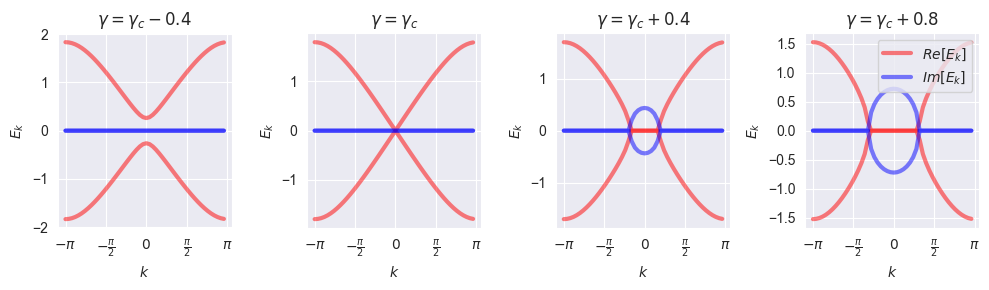

In [158]:
dim = 50

x_tick = [-3.14, -1.57, 0, 1.57, 3.14]
x_labs = [r'$-\pi $',r'$-\frac{\pi}{2}$', r'$0$',r'$\frac{\pi}{2}$',r'$\pi$']

k_ = (np.arange(0,dim) - dim //2) * 2*np.pi/dim

gamma1 = [gamma_c - 0.4, gamma_c , gamma_c + 0.4, gamma_c + 0.8]

ek = lambda k, th1,th2 ,gamma : np.arccos(0.00001j + np.cos(k) * np.cos(th1/2) * np.cos(th2/2) - np.cosh(gamma) * np.sin(th1/2) * np.sin(th2/2) )

fig = plt.figure(figsize = (10,3))
for i, g1 in enumerate(gamma1):
    ax = fig.add_subplot(1,4,i+1)
    ax.plot(k_,ek(k_,th1,th2,g1).real, color = "red", label = r"$Re[E_{k}]$", lw = 3, alpha = 0.5)
    ax.plot(k_,-ek(k_,th1,th2,g1).real, color = "red", lw = 3, alpha = 0.5)
    ax.plot(k_,ek(k_,th1,th2,g1).imag, color = "blue", label = r"$Im[E_{k}]$", lw = 3, alpha = 0.5)
    ax.plot(k_,-ek(k_,th1,th2,g1).imag, color = "blue", lw = 3, alpha = 0.5)
    plt.xticks(x_tick, x_labs)
    if i == 3:
        ax.legend(loc = "upper right")
    if i == 1:
        ax.set_title(r"$\gamma = \gamma_{c}$")
    elif i == 0:
        ax.set_title(r"$\gamma = \gamma_{c} - 0.4$")
    elif i == 2:
        ax.set_title(r"$\gamma = \gamma_{c} + 0.4$")
    elif i == 3:
        ax.set_title(r"$\gamma = \gamma_{c} + 0.8$")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$E_{k}$")

plt.tight_layout()
fig.savefig("Images/EpctrumNonHermitian.pdf",format= "pdf",bbox_inches = "tight")

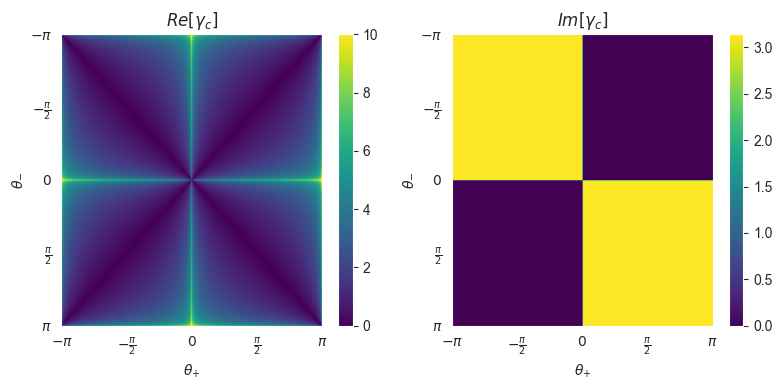

In [159]:
thp = np.arange(-np.pi, np.pi, 0.01)
thm = np.arange(-np.pi, np.pi, 0.01)
n = len(thp)
thp,thm = np.meshgrid(thp,thm)

res = np.arccosh( (np.cos(thp) * np.cos(thm) - 1) / (np.sin(thp) * np.sin(thm) + 0j) + 0.0j)
fig = plt.figure(figsize = (8,4))


ax = fig.add_subplot(121)
cax = ax.imshow(res.real, cmap = "viridis", aspect = "auto", vmax=10)
plt.colorbar(cax, ax=ax)
ax.set_xlabel(r"$\theta_{+}$")
ax.set_ylabel(r"$\theta_{-}$")
ax.set_title(r"$Re[\gamma_{c}]$")
ax.set_xticks([n // 4 * i for i in range(5)])    
ax.set_xticklabels([r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
ax.set_yticks([n // 4 * i for i in range(5)])    
ax.set_yticklabels([r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
ax.grid(False)

ax = fig.add_subplot(122)
cax = ax.imshow(res.imag, cmap = "viridis", aspect = "auto")
plt.colorbar(cax, ax=ax)
ax.set_xlabel(r"$\theta_{+}$")
ax.set_ylabel(r"$\theta_{-}$")
ax.set_title(r"$Im[\gamma_{c}]$")
ax.set_xticks([n // 4 * i for i in range(5)])    
ax.set_xticklabels([r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
ax.set_yticks([n // 4 * i for i in range(5)])    
ax.set_yticklabels([r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
ax.grid(False)

plt.tight_layout()
fig.savefig("Images/ExceptionalPoints.pdf",format= "pdf",bbox_inches = "tight")

In [179]:
dim = 10
k_ = (np.arange(0,dim) - dim //2) * 2*np.pi/dim
th1 = np.pi / 2
th2 = - np.pi / 3
g = 0
gam_list = np.arange(0,1,0.01)  

fid = []

for gam_ in gam_list:
    fid_ = []
    kk = 0
    U_ = get_U(kk,th1,th2,gam_,g)
    E,V = np.linalg.eig(U_)
    fid_.append(np.abs((V[:,0].conj() * V[:,1]).sum()))
    print(fid_)
    fid.append(fid_)

fid = np.array(fid)


[8.940697e-08]
[0.019319989]
[0.038650144]
[0.057999942]
[0.07737925]
[0.09679813]
[0.116266705]
[0.13579452]
[0.15539269]
[0.17507085]
[0.19483918]
[0.21470867]
[0.23468992]
[0.254794]
[0.2750315]
[0.29541403]
[0.3159531]
[0.3366604]
[0.35754785]
[0.37862808]
[0.3999137]
[0.42141736]
[0.44315293]
[0.46513394]
[0.48737463]
[0.50988954]
[0.53269356]
[0.5558034]
[0.57923436]
[0.60300356]
[0.62712836]
[0.6516272]
[0.6765181]
[0.7018222]
[0.7275586]
[0.7537498]
[0.780417]
[0.8075842]
[0.83527577]
[0.8635179]
[0.89233625]
[0.9217594]
[0.95181715]
[0.9825414]
[0.9862285]
[0.95591474]
[0.9267469]
[0.8986534]
[0.87156755]
[0.84542894]
[0.82018155]
[0.79577386]
[0.77215797]
[0.74928933]
[0.7271281]
[0.70563626]
[0.68477875]
[0.66452277]
[0.6448383]
[0.6256968]
[0.60707176]
[0.58893883]
[0.57127494]
[0.55405843]
[0.53726953]
[0.5208886]
[0.5048983]
[0.48928124]
[0.47402275]
[0.45910716]
[0.44452104]
[0.4302507]
[0.41628373]
[0.40260887]
[0.3892147]
[0.3760904]
[0.36322683]
[0.35061365]
[0.338242

In [180]:
print(len(gam_list))
print(fid.shape)

100
(100, 1)


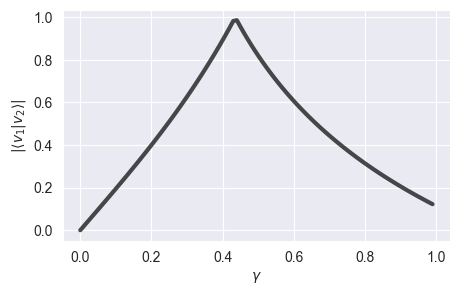

In [183]:
m,n = fid.shape
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)

for i in range(n):
    ax.plot(gam_list.real,fid[:,i].real,color = "black", lw = 3, alpha = 0.7)
ax.set_xlabel(r"$\gamma$")
ax.set_ylabel(r"$|\langle v_{1}|v_{2}\rangle|$")
fig.savefig("Images/VectorsEP.pdf",format= "pdf",bbox_inches = "tight")